Optimal point (v1, v2): [1.0000000e+00 2.8467257e-17]
Optimal lambda1: -1.142857142857143
Optimal lambda2: 5.2857142857142865
Optimal value of the objective function: 4.000000000000001


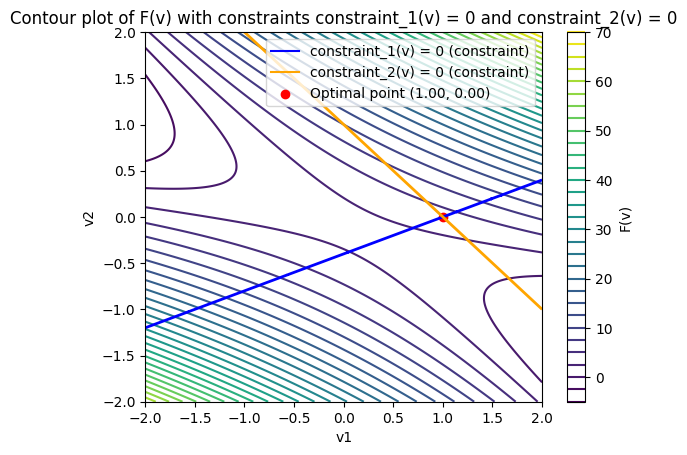

In [4]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

# Define the objective function F(v)
def objective_function(v):
    M = np.array([[1, 3], [5, 7]])  # Quadratic matrix
    p = np.array([1, 1])  # Linear term
    constant_val = 2  # Constant
    # Quadratic form: F(v) = v.T @ M @ v + p.T @ v + c
    return v.T @ M @ v + p.T @ v + constant_val

# Define the constraint functions
def constraint_1(v):
    return 2 * v[0] - 5 * v[1] - 2  # constraint_1(v) = 2*v1 - 5*v2 - 2 = 0

def constraint_2(v):
    return v[0] + v[1] - 1  # constraint_2(v) = v1 + v2 - 1 = 0

# Define the KKT conditions (gradients)
def kkt_solver():
    M = np.array([[2, 6], [10, 14]])  # 2*M matrix for the quadratic form
    p = np.array([1, 1])  # Gradient of the linear part
    
    # Jacobian of the constraints
    jacobian_matrix = np.array([[2, -5], [1, 1]])
    
    # Create the KKT system for solving v1, v2, lambda1, lambda2
    left_hand_side = np.block([
        [M, -jacobian_matrix.T],  # Top-left: Hessian, Top-right: Constraint gradients
        [jacobian_matrix, np.zeros((2, 2))]  # Bottom-left: Constraint gradients, Bottom-right: Zero matrix
    ])
    
    # RHS contains the gradient of the objective and the negative constraints
    right_hand_side = -np.concatenate((p, [constraint_1([0, 0]), constraint_2([0, 0])]))  # Constraint violations at the origin
    
    # Solve the system of linear equations
    solution_vector = solve(left_hand_side, right_hand_side)
    
    return solution_vector[:2], solution_vector[2], solution_vector[3]  # Return v1, v2, lambda1, lambda2

# Solve the KKT system
v_optimal, lagrange1_optimal, lagrange2_optimal = kkt_solver()

# Print the solution
print(f"Optimal point (v1, v2): {v_optimal}")
print(f"Optimal lambda1: {lagrange1_optimal}")
print(f"Optimal lambda2: {lagrange2_optimal}")
print(f"Optimal value of the objective function: {objective_function(v_optimal)}")

# Plotting F(v), constraint_1(v), and constraint_2(v) on the same 2D plot
v1_values = np.linspace(-2, 2, 400)
v2_values = np.linspace(-2, 2, 400)
V1_grid, V2_grid = np.meshgrid(v1_values, v2_values)

# Compute F(v) over the grid
Z_objective = np.array([objective_function(np.array([v1, v2])) for v1, v2 in zip(V1_grid.flatten(), V2_grid.flatten())]).reshape(V1_grid.shape)

# Compute constraint_1(v) and constraint_2(v) over the grid
Z_constraint_1 = constraint_1(np.array([V1_grid, V2_grid]))
Z_constraint_2 = constraint_2(np.array([V1_grid, V2_grid]))

# Plot the contour plot for F(v)
plt.contour(V1_grid, V2_grid, Z_objective, levels=30, cmap='viridis')
plt.colorbar(label='F(v)')

# Plot the constraint lines for constraint_1(v) = 0 and constraint_2(v) = 0
contour_constraint_1 = plt.contour(V1_grid, V2_grid, Z_constraint_1, levels=[0], colors='blue', linewidths=2)
contour_constraint_2 = plt.contour(V1_grid, V2_grid, Z_constraint_2, levels=[0], colors='orange', linewidths=2)

# Adding the labels to the contour plots manually
plt.plot([], [], color='blue', label='constraint_1(v) = 0 (constraint)')
plt.plot([], [], color='orange', label='constraint_2(v) = 0 (constraint)')

# Mark the optimal solution
plt.scatter(v_optimal[0], v_optimal[1], color='red', label=f'Optimal point ({v_optimal[0]:.2f}, {v_optimal[1]:.2f})')

# Set labels and title
plt.xlabel('v1')
plt.ylabel('v2')
plt.title('Contour plot of F(v) with constraints constraint_1(v) = 0 and constraint_2(v) = 0')
plt.legend(loc='upper right')
plt.show()


Optimal point (z1, z2): [1.00000000e+00 3.17206578e-17]
Optimal lambda1: -0.5714285714285714
Optimal lambda2: 5.2857142857142865


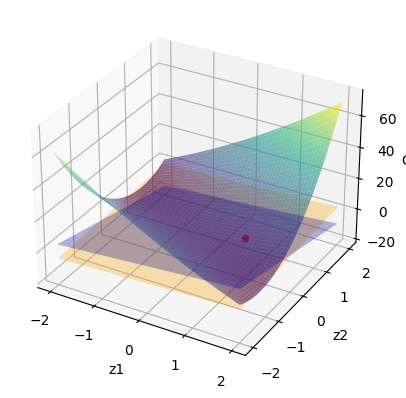

In [3]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Define the quadratic objective function G(z)
# This represents a quadratic form: G(z) = z.T @ Q @ z + r.T @ z + constant
def objective_func(z):
    Q = np.array([[1, 3], [5, 7]])  # Quadratic matrix
    r = np.array([1, 1])  # Linear term
    const_term = 2  # Constant
    # Using einsum to compute the quadratic form efficiently
    return np.einsum('ij,ij->i', z @ Q, z) + r @ z.T + const_term

# Define the first constraint function c1(z)
# This corresponds to c1(z) = 2*z1 - 5*z2 - 2
def constraint_c1(z):
    return np.array([2 * z[0] - 5 * z[1] - 2])  # Returns a 1D array for fsolve

# Define the second constraint function c2(z)
# This corresponds to c2(z) = z1 + z2 - 1
def constraint_c2(z):
    return np.array([z[0] + z[1] - 1])  # Returns a 1D array for fsolve

# Define the Lagrangian function combining the objective function and constraints
def lagrangian_func(z, *lambdas):
    lambda1, lambda2 = lambdas
    return objective_func(z) - lambda1 * constraint_c1(z) - lambda2 * constraint_c2(z)

# Gradient of the Lagrangian function with respect to z
# This calculates the gradient for solving the optimization problem
def lagrangian_grad(z, lambda1, lambda2):
    Q = np.array([[1, 3], [5, 7]])  # The matrix from G(z)
    r = np.array([1, 1])  # Linear coefficients from G(z)
    # Gradient of Lagrangian: 2*Q @ z + r - constraint gradients scaled by lambda1 and lambda2
    return 2 * Q @ z + r - 2 * lambda1 * np.array([2, -5]) - lambda2 * np.array([1, 1])

# Initial guess for decision variables (z1, z2)
initial_guess_z = np.array([0.5, 0.5])

# Function that fsolve will use to solve the system of equations
# Concatenates the gradients of the Lagrangian and the constraint functions
def system_eqs(z_lambda):
    z = z_lambda[:2]  # First two elements are the decision variables z1 and z2
    lambda1, lambda2 = z_lambda[2:]  # Last two elements are the Lagrange multipliers
    # Concatenate the gradient of the Lagrangian and the constraint functions
    return np.concatenate((lagrangian_grad(z, lambda1, lambda2), constraint_c1(z), constraint_c2(z)))

# Initial guess for decision variables (z1, z2) and Lagrange multipliers (lambda1, lambda2)
initial_guess_z_lambda = np.array([0.5, 0.5, 1, 1])

# Solve the system of equations using fsolve to find the optimal z and Lagrange multipliers
solution = fsolve(system_eqs, initial_guess_z_lambda)

# Extract the optimal z and Lagrange multiplier values from the solution
optimal_z = solution[:2]  # Optimal decision variables (z1, z2)
optimal_lambda1 = solution[2]  # Optimal Lagrange multiplier lambda1
optimal_lambda2 = solution[3]  # Optimal Lagrange multiplier lambda2

# Print the results
print("Optimal point (z1, z2):", optimal_z)
print("Optimal lambda1:", optimal_lambda1)
print("Optimal lambda2:", optimal_lambda2)

# Set up a grid of z1 and z2 values for plotting
z1_vals = np.linspace(-2, 2, 100)
z2_vals = np.linspace(-2, 2, 100)
Z1_grid, Z2_grid = np.meshgrid(z1_vals, z2_vals)  # Create a grid for z1 and z2

# Flatten the grid points and combine them for evaluating the function G(z)
flat_grid_points = np.array([Z1_grid.flatten(), Z2_grid.flatten()]).T
# Calculate G(z) over the grid points and reshape it for plotting
Z_values = objective_func(flat_grid_points).reshape(Z1_grid.shape)

# Create a 3D plot of the objective function G(z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface for the objective function G(z)
ax.plot_surface(Z1_grid, Z2_grid, Z_values, cmap='viridis', alpha=0.6)

# Mark the optimal point (solution found by fsolve)
ax.scatter(optimal_z[0], optimal_z[1], objective_func(np.array([optimal_z]))[0], color='red', marker='o')

# Plot the constraint surfaces in 3D space for visualization
# First constraint: c1(z) = 2*z1 - 5*z2 - 2
ax.plot_surface(Z1_grid, Z2_grid, 2 * Z1_grid - 5 * Z2_grid - 2, color='blue', alpha=0.3)
# Second constraint: c2(z) = z1 + z2 - 1
ax.plot_surface(Z1_grid, Z2_grid, Z1_grid + Z2_grid - 1, color='orange', alpha=0.3)

# Label the axes
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('G(z)')
plt.show()
